In [174]:
import cv2
import os
import random
import math
import numpy as np
import pandas as pd
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt

In [116]:
# img_dir = os.listdir('chars_original')
# for img_name in img_dir:
#     img = cv2.imread(os.path.join('chars_original', img_name), 0)
#     _, thrs = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
#     op_img = cv2.GaussianBlur(thrs, (3,3), 1, 1)
#     cv2.imwrite('op_chars/' + img_name, op_img)

In [175]:
class ImageGenerator:
    def __init__(self, save_path='/'):
        self.save_path = save_path
        
        # plates (ratio 9:4, X = 162px, Y = 72px)
        self.plate_path = 'plates/'
        self.plate_name_list = os.listdir(self.plate_path)
        self.char_y = 12
        # self.plate_list = []
        # for plate_name in plate_name_list:
        # img = cv2.imread(os.path.join(plate_path, plate_name))
        # self.plate_list.append(img)
        
        # characters (X = 17px, Y = 25px)
        char_path = 'chars/'
        char_name_list = os.listdir(char_path)
        self.char_list = []
        for char_name in char_name_list:
            img = cv2.imread(os.path.join(char_path, char_name))
            resize_img = cv2.resize(img, (17,25))
            self.char_list.append({'img': resize_img, 'name': char_name.split('.')[0]})
            
        # numbers (X = 17px, Y = 25px)
        number_path = 'numbers/'
        num_name_list = os.listdir(number_path)
        self.num_list = []
        for num_name in num_name_list:
            img = cv2.imread(os.path.join(number_path, num_name))
            resize_img = cv2.resize(img, (17,25)) if not '1' in num_name else cv2.resize(img, (12,25))
            self.num_list.append({'img': resize_img, 'name': num_name.split('.')[0]})
        
        # province
        self.font = ImageFont.truetype("Sarun's ThangLuang.ttf", 17)
        province_df = pd.read_csv('provinces.csv')
        self.province_list = province_df.iloc[:,1].values
        
    def concatenate_char(self, char_list, prefix=3):
        blank = np.full((25,2,3), 255, dtype='uint8')
        tab = np.full((25,14,3), 255, dtype='uint8')
        temp_list = []
        for i in range(len(char_list)):
            temp_list.append(char_list[i])
            if prefix == (i+1):
                temp_list.append(tab)
            else:
                if len(char_list) == (i+1):
                    pass
                else:
                    temp_list.append(blank)
        concat_img = cv2.hconcat(temp_list)
        return concat_img
    
    def random_char(self):
        char_list, name_list = [], []
        chars_in_plate = random.choice([6,7])
        prefix = 3 if chars_in_plate == 7 else 2
        for i in range(chars_in_plate):
            if i < prefix:
                if prefix == 3 and i == 0:
                    rand = random.choice(self.num_list)
                    char_list.append(rand['img'])
                    name_list.append(rand['name'])
                else:
                    rand = random.choice(self.char_list)
                    char_list.append(rand['img']) 
                    name_list.append(rand['name'])
            else:
                rand = random.choice(self.num_list)
                char_list.append(rand['img'])
                name_list.append(rand['name'])
        return {'img': self.concatenate_char(char_list, prefix), 'name': name_list}
    
    def gen_lp(self):
        plate = cv2.imread(os.path.join(self.plate_path, random.choice(self.plate_name_list)))
        rand = self.random_char()
        chars_img, name_img = rand['img'], rand['name']
        w, h = chars_img.shape[1], chars_img.shape[0]
        plate[self.char_y:self.char_y+h, math.floor((plate.shape[1]-w)/2):plate.shape[1]-math.ceil((plate.shape[1]-w)/2), :] = chars_img
        pil_img = Image.fromarray(plate)
        draw = ImageDraw.Draw(pil_img)
        province = random.choice(self.province_list)
        w, h = draw.textsize(province, font=self.font)
        draw.text(((162-w)/2, 37), province, fill=(0,0,0,255), font=self.font)  
        return {'img': np.array(pil_img), 'name': name_img}

In [176]:
def image_augmentation(img):
    # perspective
    w, h, _ = img.shape
    pts1 = np.float32([[0, 0], [0, w], [h, 0], [h, w]])
    begin, end = 0, 25
    pts2 = np.float32([[random.randint(begin, end), random.randint(begin, end)],
                       [random.randint(begin, end), w - random.randint(begin, end)],
                       [h - random.randint(begin, end), random.randint(begin, end)],
                       [h - random.randint(begin, end), w - random.randint(begin, end)]])
    M = cv2.getPerspectiveTransform(pts1, pts2)

    img = cv2.warpPerspective(img, M, (h, w))

    # Brightness
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img = np.array(img, dtype=np.float64)
    random_bright = .4 + np.random.uniform()
    img[:, :, 2] = img[:, :, 2] * random_bright
    img[:, :, 2][img[:, :, 2] > 255] = 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    # Blur
    blur_value = random.randint(0,1) * 2 + 1
    img = cv2.GaussianBlur(img,(blur_value, blur_value), 0.6)

    return img

In [177]:
img_gen = ImageGenerator()

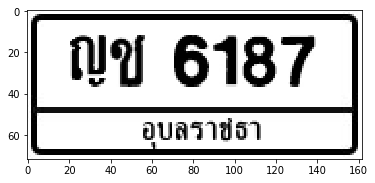

In [164]:
img = img_gen.gen_lp()
plt.imshow(img['img'])

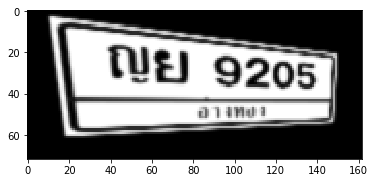

In [159]:
plt.imshow(image_augmentation(img['img']))

In [178]:
num_desire = 10
save_path = 'img_gen'
img_gen = ImageGenerator()
for i in range(num_desire):
    gen = img_gen.gen_lp()
    img, name_list = gen['img'], gen['name']
    image_aug = image_augmentation(img)
    name = ''
    for i in range(len(name_list)):
        name += name_list[i]
        if i != (len(name_list)-1):
            name += '-'
    cv2.imwrite(os.path.join(save_path, name + '.jpg'), image_aug)